# Download ERA5 data for full domain
ERA5 needs to be downloaded through the Copernicus Data Store. Processing time on the CDS side is mostly independent from domain size. For example:
- Downloading 1 month of data for a basin that covers 1 ERA5 grid cell takes in the order of several minutes;
- Downloading 1 month of data for a spatial doamin that includes all basins takes in the order of 20 minutes.

It is thus vastly more time-efficient to download data for the whole continent first, and subset to individual basins later. 

We need to download data for the largest time period required by the data, so we need to determine that too.

We want to extract data on a per-month basis, particularly for MARS request (i.e. tape archive) because this maximizes the amount of information we extract from a single tape. This prevents unnecessary tape switching. This hopefully strikes a good balance between needs.

See:
- https://confluence.ecmwf.int/display/UDOC/Retrieve#Retrieve-Datacollocation

In [2]:
import sys
import concurrent.futures
from datetime import datetime, timedelta
import pandas as pd
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import python_cs_functions as cs

### Config handling

In [3]:
# Specify where the config file can be found
config_file = '../0_config/config.txt'

In [9]:
# Get the required info from the config file
data_path = cs.read_from_config(config_file,'data_path')

# CAMELS-spat metadata
cs_meta_path = cs.read_from_config(config_file,'cs_basin_path')
cs_meta_name = cs.read_from_config(config_file,'cs_meta_name')
cs_unusable_name = cs.read_from_config(config_file,'cs_unusable_name')

# Basin folder
cs_basin_folder = cs.read_from_config(config_file, 'cs_basin_path')
basins_path = Path(data_path) / cs_basin_folder

# Merged shape
merged_shape_folder = cs.read_from_config(config_file, 'merged_shp_dir')
merged_shape_name   = cs.read_from_config(config_file, 'merged_shp_name')

# Temporary download path
temp_folder = Path( cs.read_from_config(config_file, 'temp_path') )

In [5]:
# Specify the paths
merged_shape_path = Path(data_path) / cs_basin_folder / merged_shape_folder

In [11]:
temp_folder.mkdir(parents=True, exist_ok=True)

### Data loading

In [12]:
# CAMELS-spat metadata file
cs_meta_path = Path(data_path) / cs_meta_path
cs_meta = pd.read_csv(cs_meta_path / cs_meta_name)

In [13]:
# Open list of unusable stations; Enforce reading IDs as string to keep leading 0's
cs_unusable = pd.read_csv(cs_meta_path / cs_unusable_name, dtype={'Station_id': object}) 

## Processing

### Define the spatial extent of the whole domain

In [14]:
# Find bounding box
bounds = cs.find_shapefile_bounds(merged_shape_path/merged_shape_name)

In [15]:
# Convert bounding box to download coordinates
coords_era5, _, _ = cs.find_download_coords_from_bounds(bounds, target='ERA5')

In [16]:
print(f'Spatial extent of download domain \nBounds : {bounds} \nCoords : {coords_era5}')

Spatial extent of download domain 
Bounds : [-143.87791667   26.95125     -52.80791667   69.35791667] 
Coords : 69.25/-144.0/27.0/-52.75


### Define the temporal extent of the whole domain

In [17]:
# Start with some dates that we will overwrite with the true values in the next cell
start_date = '2023-12-31' 
final_date = '1900-01-01'

In [18]:
for ix,row in cs_meta.iterrows():

    # Check if any flow observations are missing
    missing = cs.flow_obs_unavailable(cs_unusable, row.Country, row.Station_id)
    if 'iv' in missing and 'dv' in missing: 
        continue # with next station, because we have no observations at all for this station

    # From meta-data, get download period
    times_flow = cs.find_flow_obs_times_from_metadata(row, missing)
    times_era5 = cs.round_flow_obs_to_days(times_flow)

    # Compare these times with what we already have, and update if we need to extend the download window on either side
    start_date = min(start_date, times_era5[0])
    final_date = max(final_date, times_era5[1])

In [23]:
# Convert to datetimes
start_date = datetime.strptime(start_date, '%Y-%m-%d')
final_date = datetime.strptime(final_date, '%Y-%m-%d')

In [19]:
print(f'Temporal extent of download domain \nStart : {start_date} \nEnd   : {final_date}')

Temporal extent of download domain 
Start : 1950-01-01 
End   : 2023-01-03


### Download the data

In [ ]:
# Get the time-invariant data
cs.download_era5_time_invariant_data_to_netcdf(coords_era5, temp_folder/'ERA5_2023-01-01_invariants.nc')

In [24]:
# Convert start and end dates into two lists of start and end dates, that we'll iterate over
start_list,end_list = cs.convert_start_and_end_dates_to_era5_download_lists(start_date,final_date)

In [51]:
# Function to call inside the parallel loop
def download_era5(start, end):

    # Convert to relevant
    yyyy_mm = start.strftime('%Y-%m') # filename
    start   = start.strftime('%Y-%m-%d') # yyyy-mm-dd for use with cdsapi
    end     = end.strftime('%Y-%m-%d')

    # Download
    cs.download_era5_surface_level_data_to_netcdf(coords_era5, start, end, temp_folder/f'ERA5_{yyyy_mm}_surface_variables.nc')
    cs.download_era5_pressure_level_data_to_netcdf(coords_era5, start, end, temp_folder/f'ERA5_{yyyy_mm}_pressure_variables.nc')

    return print('Download successful')

In [42]:
test_s = start_list[:4]
test_e = end_list[:4]

In [40]:
# Number of threads or processes to use
num_workers = 2  # Adjust as needed

In [ ]:
with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
    results = list( executor.map(download_era5, test_s, test_e) )

Download successful


2023-08-22 13:50:04,827 INFO Welcome to the CDS
2023-08-22 13:50:04,827 INFO Welcome to the CDS
2023-08-22 13:50:04,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-08-22 13:50:04,827 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-08-22 13:50:05,085 INFO Request is queued
2023-08-22 13:50:05,101 INFO Request is queued
2023-08-22 13:50:06,306 INFO Request is running
2023-08-22 13:56:26,902 INFO Request is running
2023-08-22 13:56:26,912 INFO Request is completed
2023-08-22 13:56:26,912 INFO Downloading https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data1/adaptor.mars.internal-1692734047.052998-7002-14-f2ad91fe-22d3-4a5a-af06-9fb800cc84be.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-02_surface_variables.nc (558.3M)
2023-08-22 13:57:07,842 INFO Download rate 13.6M/s   


Successfully downloaded C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-02_surface_variables.nc


2023-08-22 13:57:08,243 INFO Welcome to the CDS
2023-08-22 13:57:08,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2023-08-22 13:57:08,469 INFO Request is queued
2023-08-22 14:00:27,330 INFO Request is completed
2023-08-22 14:00:27,330 INFO Downloading https://download-0000-clone.copernicus-climate.eu/cache-compute-0000/cache/data1/adaptor.mars.internal-1692734337.7442143-536-12-d805660b-db92-4931-8f2d-179170a4e740.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-03_surface_variables.nc (618.1M)
2023-08-22 14:01:40,024 INFO Download rate 8.5M/s    


Successfully downloaded C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-03_surface_variables.nc


2023-08-22 14:01:40,442 INFO Welcome to the CDS
2023-08-22 14:01:40,442 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2023-08-22 14:01:40,663 INFO Request is queued
2023-08-22 14:05:29,049 INFO Request is running
2023-08-22 14:10:01,230 INFO Request is running
2023-08-22 14:11:31,582 INFO Request is completed
2023-08-22 14:11:31,582 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data9/adaptor.mars.external-1692734965.3097308-26368-5-ec1f78ce-bf81-4b42-b286-5097fc325b23.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-02_pressure_variables.nc (319M)
2023-08-22 14:11:55,927 INFO Download rate 13.1M/s   


Successfully downloaded C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-02_pressure_variables.nc
Download successful


2023-08-22 14:11:56,338 INFO Welcome to the CDS
2023-08-22 14:11:56,338 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels
2023-08-22 14:11:56,607 INFO Request is queued
2023-08-22 14:11:57,819 INFO Request is running
2023-08-22 14:16:02,504 INFO Request is completed
2023-08-22 14:16:02,504 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data6/adaptor.mars.external-1692735261.6455355-24694-13-4cf3adc8-f066-4bb2-b80a-34f7c31d2170.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-03_pressure_variables.nc (353.2M)
2023-08-22 14:16:29,465 INFO Download rate 13.1M/s   


Successfully downloaded C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-03_pressure_variables.nc
Download successful


2023-08-22 14:18:17,685 INFO Request is completed
2023-08-22 14:18:17,685 INFO Downloading https://download-0015-clone.copernicus-climate.eu/cache-compute-0015/cache/data3/adaptor.mars.internal-1692735375.078634-1435-4-404badcc-786a-4a4f-a1dd-0329f0776a16.nc to C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-04_surface_variables.nc (598.1M)
2023-08-22 14:19:57,589 INFO Download rate 6M/s      
2023-08-22 14:19:58,701 INFO Welcome to the CDS


Successfully downloaded C:\Globus endpoint\CAMELS_spat\camels-spat-data\temp\ERA5_1950-04_surface_variables.nc


2023-08-22 14:19:58,701 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-complete
2023-08-22 14:19:58,929 INFO Request is queued


In [ ]:
results

## Checks

### Match domain and bounding box

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [11]:
shp = gpd.read_file(merged_shape_path/merged_shape_name)

In [12]:
# define the bounding box as a patch object
bounds = cs.find_shapefile_bounds(merged_shape_path/merged_shape_name)
bounding_box = Rectangle((bounds[0],bounds[1]),bounds[2]-bounds[0],bounds[3]-bounds[1], edgecolor='r', facecolor='None')

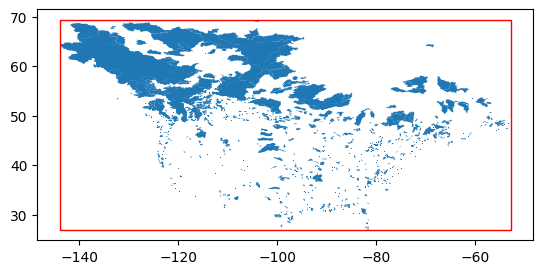

In [13]:
# figure
ax = plt.subplot()
shp.plot(ax=ax)
ax.add_patch(bounding_box)